# Top Trendings do Twitter
**Objetivos:** Desenvolver uma aplicação para monitorar o top trending e seu devido volume na rede social com o passar do tempo.

## Funcionalidades
**Requisitos funcionais obrigatorios**:
- [x] Utilizar a api do twitter para consumir o top trending e seu devido volume.
- [x] Armazenar o histórico das trendings em um banco de dados noSQL.
- [ ] Utilizar alguma biblioteca gráfica para exibir os dados.

**Requisito funcional opcional**:
- [ ] Utilizar IA para análise de sentimento dos tweets referentes aos top trendings

### Instação das Bibliotecas
Para instalar as bibliotecas, será usado um arquivo de texto com todas as dependências necessarias para este projeto funcionar.

In [ ]:
! python -m pip install -r requirements.txt

### Imports

In [1]:
import re
import json
import pprint

import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bson import json_util

from modules import mongoDb
from modules import fileToDic as fd
from modules import apiKeys as api
from modules import mongoEnv

## Funcionalidade 1: Consome o top trending e seu devido volume.

1. Abrir o arquivo `WOEID.txt` para poder ler os paises e seu identificadores.
2. Usando a função `dictionary` que esta no arquivo `fileToDic`, o arquivo com os paises e seus respectivos valores serão convertidos em dicionario.
3. Usando o dicionario `key` que está no arquivo `apiKeys`, o valor do `BEARER_TOKEN` no arquivo `.env` será atribuido a varivel `bearer_token`. O Bearer Token será usado na autenticação da url que retorna os *trends* de um determinado pais.
4. Para buscar o trending de um determinado pais iremos usar a url: https://api.twitter.com/1.1/trends/place.json
5. Entretanto, devemos passar o parametro que no caso é o id de um pais.

Fonte: https://developer.twitter.com/en/docs/twitter-api/v1/trends/trends-for-location/api-reference/get-trends-place

In [2]:
countries = {}
file = open("input/WOEID.txt")
countries = fd.dictionary(file, countries)

bearer_token = api.key['bearer_token']

search_url = "https://api.twitter.com/1.1/trends/place.json"

query_params = {'id': countries['BRAZIL'], 'exclude': 'hashtags'}

Está função usa o *bearer token* para poder realizar a autenticação, por mais que não irá logar no **twitter** o *bearer token* "representa uma autorização do Server emitida para o client. Por sua vez, o client deve possuir mecanismos próprios para identificar e validar o Token".

Fonte: [Bruno Brito](https://www.brunobrito.net.br/jwt-cookies-oauth-bearer/).

In [3]:
def bearer_oauth(r):
  '''
  Autenticação usando o bearer token
  '''
  r.headers["Authorization"] = f"Bearer {bearer_token}"
  r.headers["User-Agent"] = "v2RecentSearchPython"

  return r

Usando a url e o parametros necessario, a função abaixo retorna um *response* no formato **json**. Veja onde a função `bearer_oauth` será usada.

Fonte: https://github.com/twitterdev/Twitter-API-v2-sample-code/blob/main/Recent-Search/recent_search.py

In [4]:
def connect_to_endpoint(url, params):
  '''
  Se conecta a url dada com o parametros dado.
  Consultar a documentação para saber o parametros nessario na pesquisa
  '''
  response = requests.get(url, auth=bearer_oauth, params=params)
  print(response.status_code)
  if response.status_code != 200:
    raise Exception(response.status_code, response.text)
        
  return response.json()

## Funcionalidade 2: Persistir os dados

1. criar conexão com o banco, neste projeto usando o MongoDb
2. Criar um banco chamado `tweets_db`
3. Criar uma coleção chamada `top_trends`
4. Inserir a *response* nesta coleção

Fonte: https://pymongo.readthedocs.io/en/stable/tutorial.html

### Variaveis de Ambiente

In [5]:
username = mongoEnv.key_mongo['mongo_username']
pwd = mongoEnv.key_mongo['mongo_password']

### Conexão com banco de dados

In [6]:
mongo_client = mongoDb.connect_to_mongo(username, pwd, '27017')

### Criação do Banco de Dados e a Coleção

In [7]:
database = mongoDb.create_db(mongo_client, 'tweets_db')
collection = database['top_trends']

### Conectando ao Endpoint da Twitter API

In [8]:
top_trends = connect_to_endpoint(search_url, query_params)

200


### Persistindo os dados encontrado no Json
Aqui eu decidi fazer um for para inserir um de cada vez, porém eu observei que só foi criado um unico documento, sendo que os top trendings é uma lista com os 50 top trendings da data atual.

In [9]:
for trend in top_trends:
    trend_id = collection.insert_one(trend).inserted_id

### Procurando e Printando o primeiro documento

In [11]:
pprint.pprint(collection.find_one())

{'_id': ObjectId('6147193c5b64b01e186febf6'),
 'as_of': '2021-09-19T11:04:28Z',
 'created_at': '2021-09-15T02:00:22Z',
 'locations': [{'name': 'Brazil', 'woeid': 23424768}],
 'trends': [{'name': '#Calamidade',
             'promoted_content': None,
             'query': '%23Calamidade',
             'tweet_volume': 286336,
             'url': 'http://twitter.com/search?q=%23Calamidade'},
            {'name': 'Otis',
             'promoted_content': None,
             'query': 'Otis',
             'tweet_volume': 59009,
             'url': 'http://twitter.com/search?q=Otis'},
            {'name': 'Paulo Freire',
             'promoted_content': None,
             'query': '%22Paulo+Freire%22',
             'tweet_volume': 43627,
             'url': 'http://twitter.com/search?q=%22Paulo+Freire%22'},
            {'name': 'juliette no altas horas',
             'promoted_content': None,
             'query': '%22juliette+no+altas+horas%22',
             'tweet_volume': 84069,
             

            {'name': 'chico césar',
             'promoted_content': None,
             'query': '%22chico+c%C3%A9sar%22',
             'tweet_volume': None,
             'url': 'http://twitter.com/search?q=%22chico+c%C3%A9sar%22'},
            {'name': 'Rodallega',
             'promoted_content': None,
             'query': 'Rodallega',
             'tweet_volume': None,
             'url': 'http://twitter.com/search?q=Rodallega'},
            {'name': 'Khai',
             'promoted_content': None,
             'query': 'Khai',
             'tweet_volume': 18609,
             'url': 'http://twitter.com/search?q=Khai'}]}


### Printando o nome da coleção criada no banco de dados

In [12]:
database.list_collection_names()

['top_trends']

## Funcionalidade 3: Visualizando os Dados

1. Importar os dados do mongodb para o pandas
2. Usar a biblioteca pandas para criar um Dataframe dos *trends*
3. Usar a biblioteca pandas para visualizar os dados em um gráfico
4. Usar a biblioteca matplot para visualizar os dados em um gráfico 

In [13]:
trends = []
for item in top_trends:
    trends = item['trends']
    
df = pd.DataFrame(trends)
print(df)

                              name  \
0                     Paulo Freire   
1                         West Ham   
2                             kcon   
3                    José de Abreu   
4                           Panamá   
5                           Kurama   
6            HARIANY COM DUTYCOLOR   
7                        McTominay   
8                           Varane   
9           SVT NOSTALGIC CONCERTS   
10                   Daniel Guedes   
11                        O Google   
12                     Globo Rural   
13                     Zé de Abreu   
14                Moisés e Patrick   
15                          Hannie   
16                     Bom Domingo   
17  Patrono da Educação Brasileira   
18                         Lindoso   
19             PROUD OF YOU LALISA   
20                          Barion   
21                Hermione Granger   
22                        Oprimido   
23                        Eu Paulo   
24                100º Aniversário   
25          

In [14]:
df.head()

,name,url,promoted_content,query,tweet_volume
0,Paulo Freire,http://twitter.com/search?q=%22Paulo+Freire%22,None,%22Paulo+Freire%22,64651.0
1,West Ham,http://twitter.com/search?q=%22West+Ham%22,None,%22West+Ham%22,45765.0
2,kcon,http://twitter.com/search?q=kcon,None,kcon,178030.0
3,José de Abreu,http://twitter.com/search?q=%22Jos%C3%A9+de+Ab...,None,%22Jos%C3%A9+de+Abreu%22,NaN
4,Panamá,http://twitter.com/search?q=Panam%C3%A1,None,Panam%C3%A1,20687.0


In [15]:
df.shape

(45, 5)

In [16]:
df_trends = df.rename(columns={'name': 'Nome', 'url': 'URI', 'promoted_content': 'Patrocinado', 'query': 'Hashtag', 'tweet_volume': 'Volume'})

In [17]:
df_trends.head()

,Nome,URI,Patrocinado,Hashtag,Volume
0,Paulo Freire,http://twitter.com/search?q=%22Paulo+Freire%22,None,%22Paulo+Freire%22,64651.0
1,West Ham,http://twitter.com/search?q=%22West+Ham%22,None,%22West+Ham%22,45765.0
2,kcon,http://twitter.com/search?q=kcon,None,kcon,178030.0
3,José de Abreu,http://twitter.com/search?q=%22Jos%C3%A9+de+Ab...,None,%22Jos%C3%A9+de+Abreu%22,NaN
4,Panamá,http://twitter.com/search?q=Panam%C3%A1,None,Panam%C3%A1,20687.0


In [18]:
df_trends.dtypes

Nome            object
URI             object
Patrocinado     object
Hashtag         object
Volume         float64
dtype: object

In [19]:
df_trends["Volume"].fillna(0, inplace=True)

In [20]:
# Qual o volume de tweet dado um nome
df_trends.groupby("Nome")["Volume"].mean()

Nome
100º Aniversário                       0.0
Barion                                 0.0
Bom Domingo                        10344.0
Chuseok                           228517.0
Connie                                 0.0
Daniel Guedes                          0.0
Dourado                                0.0
ELE CRAVA                              0.0
Eduardo Bolsonaro                      0.0
Emmy                               23916.0
Eu Paulo                               0.0
Feliz Domingo                      21632.0
Globo Rural                            0.0
HARIANY COM DUTYCOLOR                  0.0
HOJE TEM CORINTHIANS                   0.0
HOJE TEM FLAMENGO                      0.0
Hannie                             17060.0
Harvard                            12457.0
Hermione Granger                       0.0
José de Abreu                          0.0
Kane                               25809.0
Kurama                                 0.0
Lindoso                                0.0
Lyon  

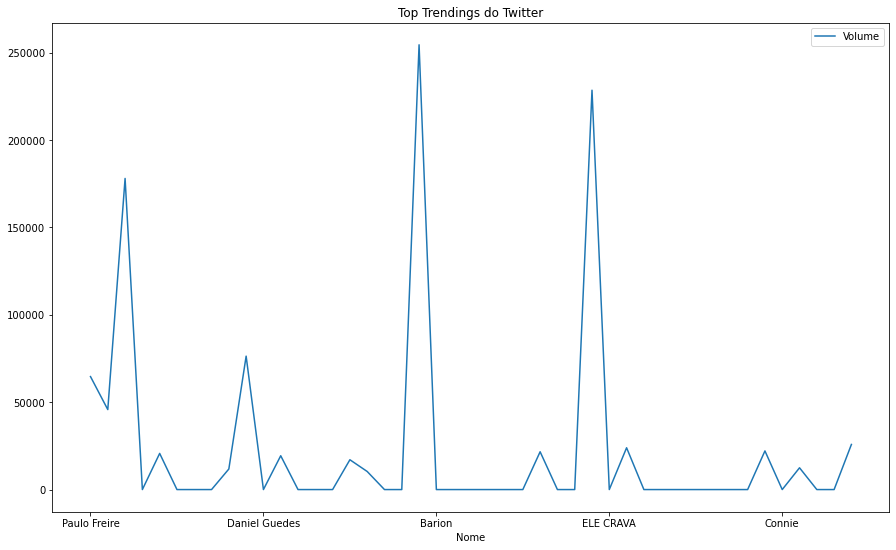

In [72]:
df_trends.plot(x="Nome", y=["Volume"], figsize=(15,9))
plt.title('Top Trendings do Twitter')
plt.show()

Text(0.5, 1.0, 'Top Trendings do Twitter')

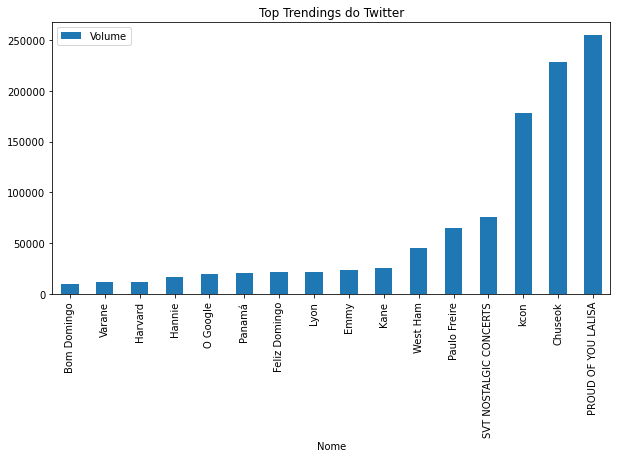

In [71]:
# Volume acima de 0
top = df_trends[df_trends["Volume"] > 0].sort_values("Volume")
top.plot(x="Nome", y=["Volume"], kind="bar", figsize=(10,5))
plt.title('Top Trendings do Twitter')

<AxesSubplot:xlabel='Nome'>

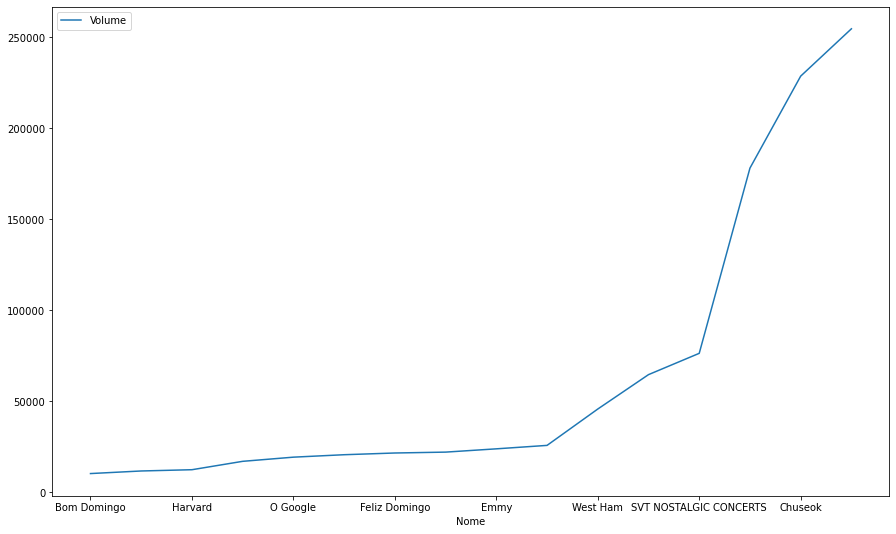

In [69]:
top = df_trends[df_trends["Volume"] > 0].sort_values("Volume")
top.plot(x="Nome", y="Volume", kind='line', figsize=(15,9))

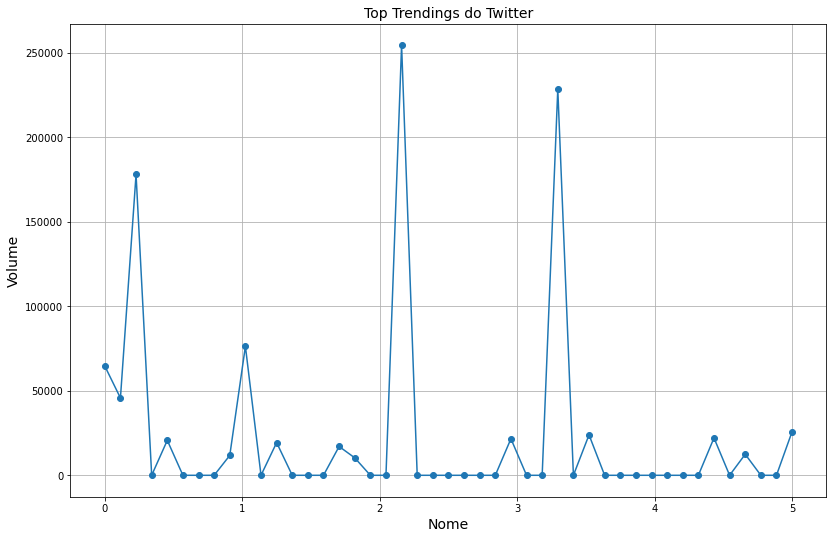

In [76]:
x = np.linspace(0.0, 5.0, 45)
fig, ax = plt.subplots(figsize=(15, 9))
fig.subplots_adjust(bottom=0.15, left=0.2)
plt.plot(x, df_trends["Volume"], marker='o')
plt.title('Top Trendings do Twitter', fontsize=14)
plt.xlabel('Nome', fontsize=14)
plt.ylabel('Volume', fontsize=14)
plt.grid(True)
plt.show()